In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score,train_test_split,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import GridSearchCV, ParameterGrid
import time as time

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
def mase(actual, forecast):
    n = len(actual)
    numerator = np.mean(np.abs(actual - forecast))
    denominator = np.mean(np.abs(np.diff(actual)))
    return numerator / denominator

In [3]:
covid_df = pd.read_csv('penn_multi_df.csv', parse_dates=['Date'])
covid_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'] = np.clip(covid_df['PEOPLE_POSITIVE_NEW_CASES_COUNT'], 0, None)
covid_df.fillna(0, inplace=True)
covid_df = covid_df.rename(columns={'Date': 'ds', 'PEOPLE_POSITIVE_NEW_CASES_COUNT': 'y'})
covid_df.set_index('ds', inplace=True)

train_size = int(len(covid_df)* 0.85)
covid_train, covid_test = covid_df[0:train_size], covid_df[train_size:]

In [4]:
covid_train = covid_train[['y', 'PEOPLE_DEATH_NEW_COUNT', 'Series_Complete_5Plus', 'new_cases_50_std', 'new_cases_4_lag', 'new_cases_10_max', 'new_cases_30_lag', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_hospitalized_patients', 'new_cases_10_std', 'new_cases_1 lag', 'new_deaths_4_lag', 'new_cases_3_lag']]
covid_test = covid_test[['y', 'PEOPLE_DEATH_NEW_COUNT', 'Series_Complete_5Plus', 'new_cases_50_std', 'new_cases_4_lag', 'new_cases_10_max', 'new_cases_30_lag', 'new_cases_10_mean', 'new_cases_10_min', 'new_cases_7_lag', 'new_hospitalized_patients', 'new_cases_10_std', 'new_cases_1 lag', 'new_deaths_4_lag', 'new_cases_3_lag']]


In [5]:
X_train = covid_train.drop(columns=['y'], axis=1)
y_train = covid_train['y']
X_test = covid_test.drop(columns=['y'], axis=1)
y_test = covid_test['y']

In [6]:
reg_model = xgb.XGBRegressor()
reg_model.fit(X_train, y_train, verbose=True)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

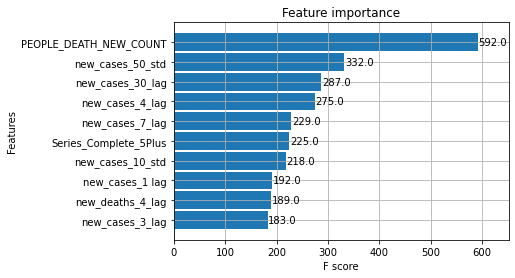

In [7]:
_ = plot_importance(reg_model, height=0.9 ,max_num_features = 10)

<AxesSubplot:xlabel='ds'>

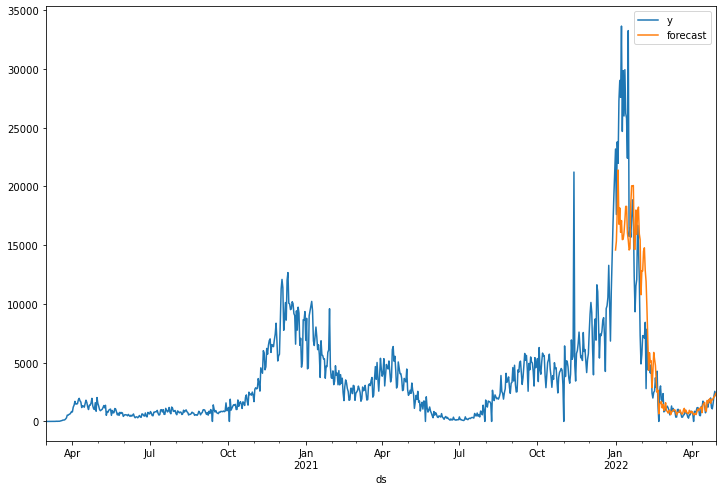

In [8]:
covid_test['forecast'] = reg_model.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast']=covid_test['forecast']

prophet_df_multi[['y', 'forecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

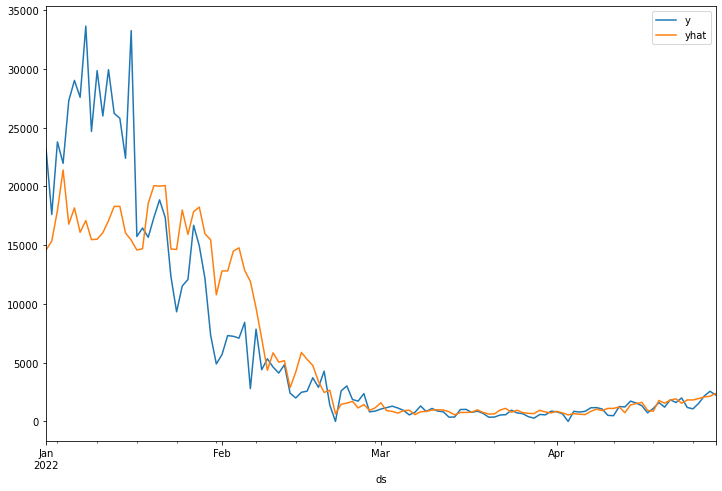

In [9]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat'] = covid_test['forecast'].values
graph_df[['y','yhat']].plot(figsize=(12,8))

In [10]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast']))

Test RMSE:  4469.555772587054
Test MAE:  2432.6770578592764
MASE =  1.637652353751859


In [11]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits = 5, test_size = 100, gap = 1)
covid_df = covid_df.sort_index()

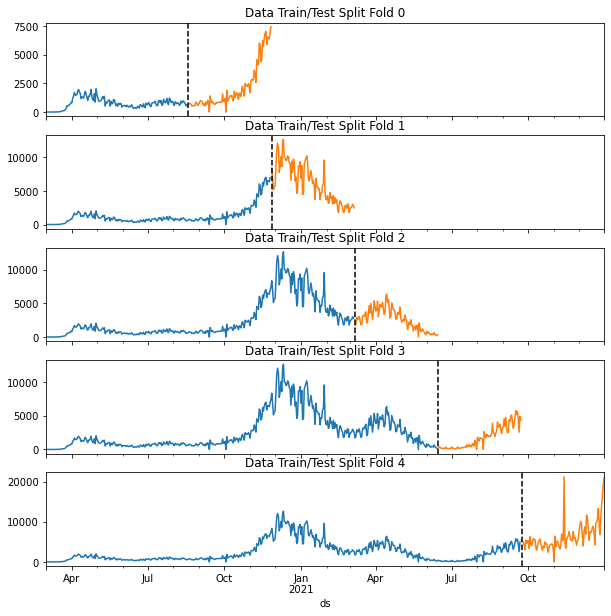

In [12]:
fig, axs = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(covid_train):
    train = covid_train.iloc[train_idx]
    test = covid_train.iloc[val_idx]
    train['y'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['y'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [13]:
tss = TimeSeriesSplit(n_splits=5, test_size=100, gap=1)
covid_df = covid_df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(covid_train):
    train = covid_train.iloc[train_idx]
    test = covid_train.iloc[val_idx]
    TARGET = 'y'

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=20,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)  

[17:34:40] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4275.97532	validation_1-rmse:11163.03238
[100]	validation_0-rmse:1865.04649	validation_1-rmse:6924.16922
[200]	validation_0-rmse:1041.17274	validation_1-rmse:5275.72634
[300]	validation_0-rmse:743.25680	validation_1-rmse:4611.89920
[400]	validation_0-rmse:621.77431	validation_1-rmse:4342.01637
[500]	validation_0-rmse:551.45784	validation_1-rmse:4288.24596
[505]	validation_0-rmse:549.21016	validation_1-rmse:4290.76928
[17:34:42] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:4275.97532	validation_1-rmse:11163.03238
[100]	validation_0-rmse:1865.04649	validation_1-rmse:6924.16922
[200]	validation_0-rmse:1041.17274	validation_1-rmse:5275.72634
[300]	validation

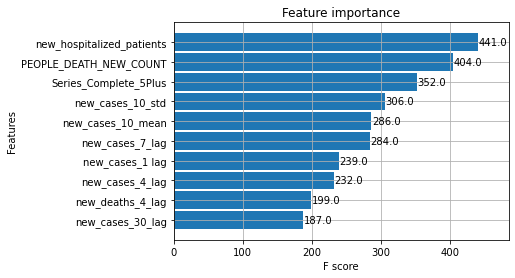

In [17]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

<AxesSubplot:xlabel='ds'>

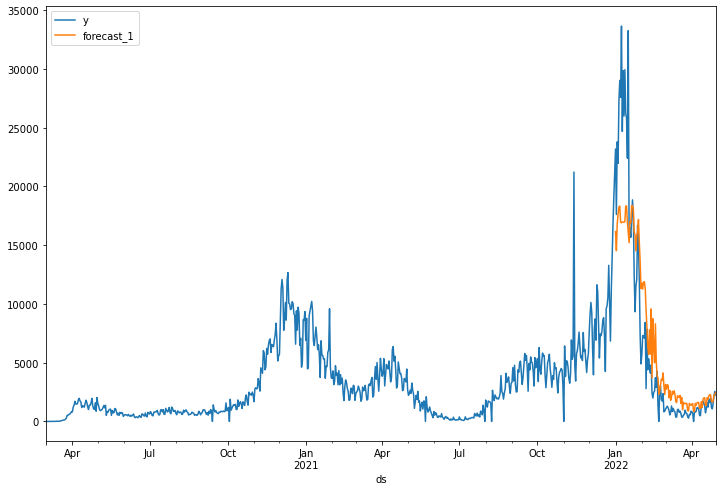

In [14]:
covid_test['forecast_1'] = reg.predict(X_test)

prophet_df_multi = pd.DataFrame(covid_df)

prophet_df_multi['forecast_1']=covid_test['forecast_1']

prophet_df_multi[['y', 'forecast_1']].plot(figsize=(12,8))

<AxesSubplot:xlabel='ds'>

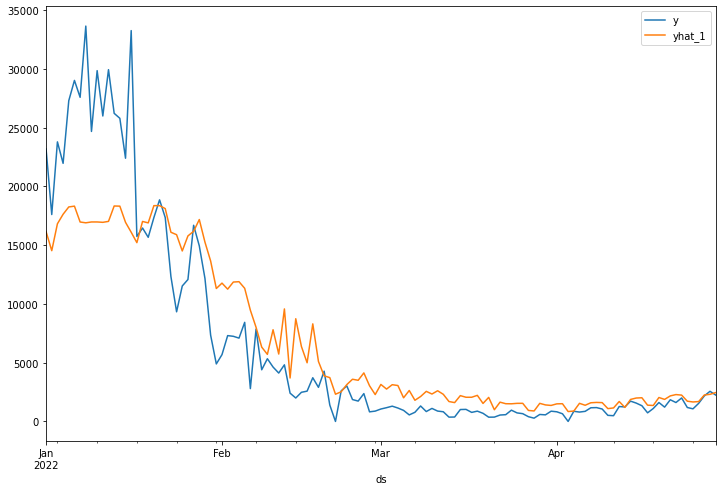

In [15]:
graph_df = pd.DataFrame(covid_test)
graph_df['yhat_1'] = covid_test['forecast_1'].values
graph_df[['y','yhat_1']].plot(figsize=(12,8))

In [16]:
model_rmse = mean_squared_error(covid_test['y'], covid_test['forecast_1'], squared=False)
model_mae = mean_absolute_error(covid_test['y'], covid_test['forecast_1'])
print('Test RMSE: ', model_rmse)
print('Test MAE: ', model_mae)
print('MASE = ', mase(covid_test['y'], covid_test['forecast_1']))

Test RMSE:  4279.997234612875
Test MAE:  2650.6625073857667
MASE =  1.7843978427790197
